In [1]:
import gc
import pickle
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
%%time
train = pd.read_csv('../data/de_dup_encoded_train.csv', dtype={'fullVisitorId': 'str'})
test = pd.read_csv('../data/de_dup_encoded_test.csv', dtype={'fullVisitorId': 'str'})
sub = pd.read_csv('../data/sample_submission_v2.csv', dtype={'fullVisitorId': 'str'})

CPU times: user 1min 10s, sys: 5.11 s, total: 1min 15s
Wall time: 1min 13s


In [8]:
features = [col for col in train.columns if 'fe' in col]

In [9]:
skf = list(StratifiedKFold(n_splits=5, random_state=36).split(train[features], train['target'] == 0))

In [96]:
models = []
train_meta = np.zeros(train.shape[0])
test_meta = np.zeros(test.shape[0])
scores = []
for idx, (train_idx, valid_idx) in enumerate(skf):
    X_train = train[features].iloc[train_idx,:]
    y_train = train['target'][train_idx]
    X_valid = train[features].iloc[valid_idx,:]
    y_valid = train['target'][valid_idx]

    print('fitting on the {}th split'.format(idx + 1))
    print('{} out of {} is non zero'.format((y_valid != 0).sum(), y_valid.shape[0]))
    reg = lgb.LGBMRegressor(
        num_leaves=7,
        learning_rate=0.01,
        n_estimators=65535,
        colsample_bytree=0.1,
        random_state=1,
        min_data_in_leaf=5,
        reg_alpha=0,
        reg_lambda=0.1,
        n_jobs=4
    )
    reg.fit(
        X_train, np.log1p(y_train),
        eval_set=[(X_valid, np.log1p(y_valid))],
        early_stopping_rounds=50,
        verbose=-1,
        eval_metric='rmse'
    )

#         lgb.plot_importance(reg, max_num_features=10)
#         plt.show()
#         plt.close()

    models.append(reg)
    valid_pred = reg.predict(X_valid, num_iteration=reg.best_iteration_)
    train_meta[valid_idx] = valid_pred
    model_score = np.sqrt(mean_squared_error(valid_pred, np.log1p(y_valid)))
    naive_score = np.sqrt(mean_squared_error(np.zeros_like(y_valid), np.log1p(y_valid)))
    print('naive score : {} -- model score: {}'.format(naive_score, model_score))
    scores.append(model_score)
    test_meta += reg.predict(test[features], num_iteration=reg.best_iteration_) / len(skf)
    del X_train, y_train, X_valid, y_valid
    gc.collect()


print('DONE! {} folds'.format(len(skf)))
print('-----', np.mean(scores), np.std(scores))
model_score = np.sqrt(mean_squared_error(train_meta, np.log1p(train['target'])))
naive_score = np.sqrt(mean_squared_error(np.zeros_like(train['target']), np.log1p(train['target'])))
print('----- naive score : {} -- model score: {}'.format(naive_score, model_score))

fitting on the 1th split
22 out of 65928 is non zero
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[229]	valid_0's l2: 0.109311	valid_0's rmse: 0.330623
naive score : 0.3320560412415828 -- model score: 0.33062262354889144
fitting on the 2th split
21 out of 65927 is non zero
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[979]	valid_0's l2: 0.0956519	valid_0's rmse: 0.309276
naive score : 0.3266241522717156 -- model score: 0.30927635924322416
fitting on the 3th split
21 out of 65927 is non zero
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[429]	valid_0's l2: 0.0973084	valid_0's rmse: 0.311943
naive score : 0.3157313689377627 -- model score: 0.3119428864372478
fitting on the 4th split
21 out of 65927 is non zero
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[415]	valid_0's l2: 0.0994118	

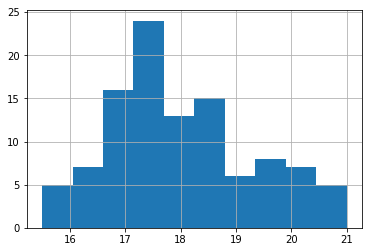

In [99]:
np.log1p(train['target'])[np.log1p(train['target']) > 0].hist()

In [98]:
pickle.dump([models, train_meta, test_meta], open('../data/lgb_model_dump.pkl', 'wb'))

In [153]:
lgb_models, lgb_train_meta, lgb_test_meta = pickle.load(open('../data/lgb_model_dump.pkl', 'rb'))

In [157]:
lgb_pred = np.clip(lgb_train_meta, 0, lgb_train_meta.max())
print(np.sqrt(mean_squared_error(lgb_pred, np.log1p(train['target']))))

0.3180504552514804


In [158]:
test_pred = np.clip(lgb_test_meta, 0, lgb_test_meta.max())
sub.PredictedLogRevenue = test_pred

In [66]:
sub.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.003190
1,0000039738481224681,0.003190
2,0000073585230191399,0.003190
3,0000087588448856385,0.003176
4,0000149787903119437,0.003176


In [69]:
sum(sub.PredictedLogRevenue > 1)

71

In [70]:
sub.to_csv('lgb_sub.csv', index=False)

fitting on the 1th split
22 out of 65928 is non zero
[0]	validation_0-rmse:0.58288
Will train until validation_0-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:0.346634
[100]	validation_0-rmse:0.331456
[150]	validation_0-rmse:0.331203
Stopping. Best iteration:
[126]	validation_0-rmse:0.331019



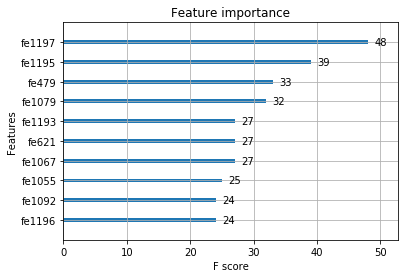

naive score : 0.3320560412415828 -- model score: 0.33102799219519885
fitting on the 2th split
21 out of 65927 is non zero
[0]	validation_0-rmse:0.579979
Will train until validation_0-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:0.33677
[100]	validation_0-rmse:0.318648
[150]	validation_0-rmse:0.316662
Stopping. Best iteration:
[145]	validation_0-rmse:0.316555



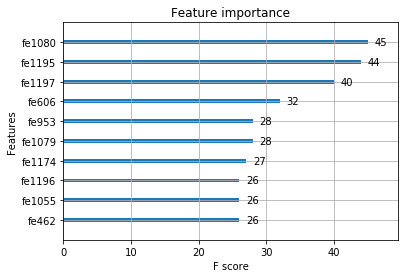

naive score : 0.3266241522717156 -- model score: 0.3165860536032598
fitting on the 3th split
21 out of 65927 is non zero
[0]	validation_0-rmse:0.574111
Will train until validation_0-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:0.330123
[100]	validation_0-rmse:0.313913
[150]	validation_0-rmse:0.313327
Stopping. Best iteration:
[129]	validation_0-rmse:0.313127



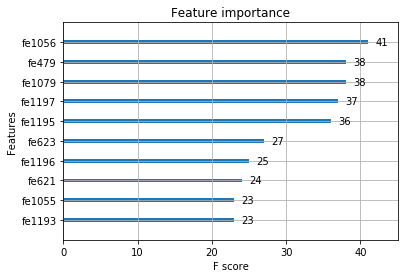

naive score : 0.3157313689377627 -- model score: 0.313189378958852
fitting on the 4th split
21 out of 65927 is non zero
[0]	validation_0-rmse:0.576793
Will train until validation_0-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:0.333757
[100]	validation_0-rmse:0.31697
[150]	validation_0-rmse:0.315879
[200]	validation_0-rmse:0.316004
Stopping. Best iteration:
[152]	validation_0-rmse:0.315792



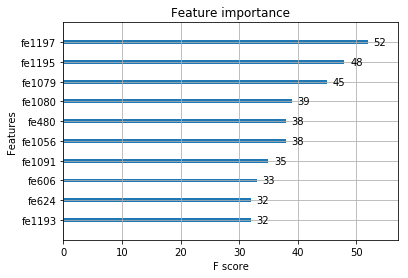

naive score : 0.32071929120976317 -- model score: 0.3158181664134478
fitting on the 5th split
21 out of 65927 is non zero
[0]	validation_0-rmse:0.5781
Will train until validation_0-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:0.338728
[100]	validation_0-rmse:0.323751
[150]	validation_0-rmse:0.323912
Stopping. Best iteration:
[116]	validation_0-rmse:0.323506



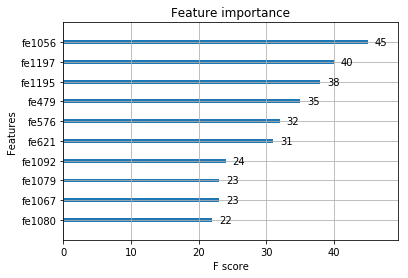

naive score : 0.3231174025051791 -- model score: 0.32352711115153715
DONE! 5 folds
----- 0.32002974046445914 0.006474257078122437
----- naive score : 0.32369635506448663 -- model score: 0.32009525516905124


In [95]:
models = []
train_meta = np.zeros(train.shape[0])
test_meta = np.zeros(test.shape[0])
scores = []
for idx, (train_idx, valid_idx) in enumerate(skf):
    X_train = train[features].iloc[train_idx,:]
    y_train = train['target'][train_idx]
    X_valid = train[features].iloc[valid_idx,:]
    y_valid = train['target'][valid_idx]

    print('fitting on the {}th split'.format(idx + 1))
    print('{} out of {} is non zero'.format((y_valid != 0).sum(), y_valid.shape[0]))
    reg = xgb.XGBRegressor(
        max_depth=5,
        learning_rate=0.03,
        n_estimators=65535,
        colsample_bytree=0.05,
        random_state=1,
        min_child_weight=7,
        reg_alpha=0,
        reg_lambda=1,
        gamma=0,
        n_jobs=4
    )
    reg.fit(
        X_train, np.log1p(y_train),
        eval_set=[(X_valid, np.log1p(y_valid))],
        early_stopping_rounds=50,
        verbose=50,
        eval_metric='rmse'
    )

    xgb.plot_importance(reg, max_num_features=10)
    plt.show()
    plt.close()

    models.append(reg)
    valid_pred = reg.predict(X_valid, ntree_limit=reg.best_iteration)
    train_meta[valid_idx] = valid_pred
    model_score = np.sqrt(mean_squared_error(valid_pred, np.log1p(y_valid)))
    naive_score = np.sqrt(mean_squared_error(np.zeros_like(y_valid), np.log1p(y_valid)))
    print('naive score : {} -- model score: {}'.format(naive_score, model_score))
    scores.append(model_score)
    test_meta += reg.predict(test[features], ntree_limit=reg.best_iteration) / len(skf)
    del X_train, y_train, X_valid, y_valid
    gc.collect()


print('DONE! {} folds'.format(len(skf)))
print('-----', np.mean(scores), np.std(scores))
model_score = np.sqrt(mean_squared_error(train_meta, np.log1p(train['target'])))
naive_score = np.sqrt(mean_squared_error(np.zeros_like(train['target']), np.log1p(train['target'])))
print('----- naive score : {} -- model score: {}'.format(naive_score, model_score))

In [96]:
pickle.dump([models, train_meta, test_meta], open('../data/xgb_model_dump.pkl', 'wb'))

In [159]:
xgb_models, xgb_train_meta, xgb_test_meta = pickle.load(open('../data/xgb_model_dump.pkl', 'rb'))

In [198]:
test_pred = np.clip(xgb_test_meta, 0, xgb_test_meta.max())
sub.PredictedLogRevenue = test_pred

In [ ]:
sub.to_csv('xgb__sub.csv', index=False)

In [160]:
np.corrcoef(lgb_train_meta, xgb_train_meta)

array([[1.       , 0.8339411],
       [0.8339411, 1.       ]])

In [161]:
xgb_pred = np.clip(xgb_train_meta, 0, xgb_train_meta.max())
print(np.sqrt(mean_squared_error(xgb_pred, np.log1p(train['target']))))

0.32009438804456963


In [162]:
from sklearn.linear_model import LinearRegression

In [186]:
# d = np.hstack([lgb_train_meta.reshape(1,-1).T, xgb_train_meta.reshape(1,-1).T])
d = np.hstack([lgb_pred.reshape(1,-1).T, xgb_pred.reshape(1,-1).T])

In [187]:
lr = LinearRegression(fit_intercept=False).fit(d, np.log1p(train['target']))

In [178]:
lr.coef_

array([ 1.3758264 , -0.15599645])

In [188]:
lr.coef_

array([ 1.38934813, -0.16913887])

In [189]:
# train_blend = 1.3758264 * lgb_train_meta - 0.15599645 * xgb_train_meta
train_blend = 1.38934813 * lgb_pred - 0.16913887 * xgb_pred
train_blend = np.clip(train_blend, a_min=0, a_max = train_blend.max())

In [185]:
print(np.sqrt(mean_squared_error(train_blend, np.log1p(train['target']))))

0.3177714367634254


In [190]:
print(np.sqrt(mean_squared_error(train_blend, np.log1p(train['target']))))

0.31777035064333703


In [193]:
lgb_test_pred = np.clip(lgb_test_meta, 0, lgb_test_meta.max())
xgb_test_pred = np.clip(xgb_test_meta, 0, xgb_test_meta.max())

In [194]:
test_blend = 1.38934813 * lgb_test_pred - 0.16913887 * xgb_test_pred
test_blend = np.clip(test_blend, a_min=0, a_max = test_blend.max())

In [195]:
sub.PredictedLogRevenue = test_blend

In [196]:
sub.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.002516
1,0000039738481224681,0.002578
2,0000073585230191399,0.002583
3,0000087588448856385,0.002606
4,0000149787903119437,0.002606


In [197]:
sub.to_csv('lgb_xgb_blend_sub.csv', index=False)